In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Editing the data

In [2]:
data=pd.read_csv('data/Boiler_emulator_dataset.txt',delimiter=",")
data.head()

,Fuel_Mdot,Tair,Treturn,Tsupply,Water_Mdot,Condition,Class
0,1,283,333.0,363.574744,3.0,%=0.05,Lean
1,1,283,333.0,362.349517,3.0,%=0.1,Nominal
2,1,283,333.0,361.216941,3.0,%=0.15,ExcessAir
3,1,283,333.0,360.166890,3.0,%=0.20,ExcessAir
4,1,283,333.0,359.190662,3.0,%=0.25,ExcessAir


In [3]:
pd.unique(data['Class'])

array(['Lean', 'Nominal', 'ExcessAir', 'Fouling', 'Scaling'], dtype=object)

In [4]:
pd.unique(data['Condition'])

array(['%=0.05', '%=0.1', '%=0.15', '%=0.20', '%=0.25', '%=0.3', '%=0.35',
       '%=0.40', '%=0.45', '%=0.50', 'F = 0.01', 'F = 0.06', 'F = 0.11',
       'F = 0.16', 'F = 0.21', 'F = 0.26', 'F = 0.31', 'F = 0.36',
       'F = 0.41', 'F = 0.46', 'S = 0.01', 'S = 0.06', 'S = 0.11',
       'S = 0.16', 'S = 0.21', 'S = 0.26', 'S = 0.31', 'S = 0.36',
       'S = 0.41', 'S = 0.46', 'Nominal'], dtype=object)

In [5]:
replacements = {'Nominal': 0, 'Lean': 1, 'ExcessAir': 2, 'Fouling': 3,'Scaling' : 4,'%=0.05' : 0.05, '%=0.1': 0.1, '%=0.15': 0.15, 
                '%=0.20': 0.2, '%=0.25' : 0.25, '%=0.3': 0.3, '%=0.35': 0.35, '%=0.40': 0.4,  '%=0.45': 0.45, '%=0.50': 0.5, 'F = 0.01': 0.01,
                'F = 0.06': 0.06, 'F = 0.11': 0.11, 'F = 0.16': 0.16, 'F = 0.21': 0.21, 'F = 0.26': 0.26, 'F = 0.31': 0.31, 'F = 0.36': 0.36,
                'F = 0.41': 0.41, 'F = 0.46': 0.46, 'S = 0.01': 0.01,'S = 0.06': 0.06, 'S = 0.11': 0.11, 'S = 0.16': 0.16, 'S = 0.21': 0.21,
                'S = 0.26': 0.26, 'S = 0.31': 0.31, 'S = 0.36': 0.36,'S = 0.41': 0.41, 'S = 0.46': 0.46 }

data=data.replace(replacements)
data.to_csv('data/data.csv', index=False)

* Labeling

In [6]:
normal=data.values[data['Class'].values==0]
normal=normal[:,0:6]
y0=np.zeros(len(normal))
lean=data.values[data["Class"].values==1]
lean=lean[:,0:6]
y1=np.ones(len(lean))
excess_air=data.values[data["Class"].values==2]
excess_air=excess_air[:,0:6]
y2=2*np.ones(len(excess_air))
fouling=data.values[data["Class"].values==3]
fouling=fouling[:,0:6]
y3=3*np.ones(len(fouling))
scaling=data.values[data["Class"].values==4]
scaling=scaling[:,0:6]
y4=4*np.ones(len(scaling))

In [7]:
X=np.concatenate([normal, lean, excess_air, fouling, scaling])
y=np.concatenate([y0, y1, y2, y3, y4])

* Filling nan/null with mean

In [8]:
df = pd.DataFrame(X)
df.fillna(df.mean(), inplace=True)
X = df.values

# t-SNE

In [9]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

t=TSNE(n_components=3,random_state=42)
X_embed=t.fit_transform(X)

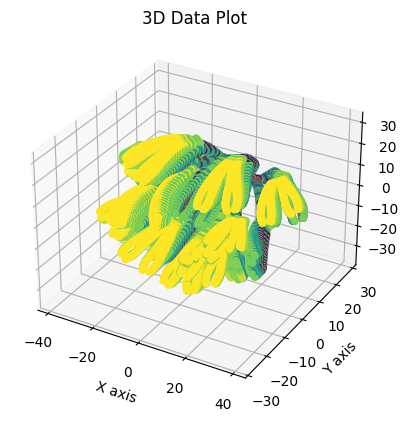

In [10]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(X_embed[:, 0], X_embed[:, 1],X_embed[:,2],c=y)

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Label')
ax.set_title('3D Data Plot')

# Show the plot
plt.show()

# AE

* 3 features output

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout

# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the dimensions of the autoencoder
input_dim = X_train.shape[1]

encoding_dim = 3


# Define the autoencoder model
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(16, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(8, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)

decoder = Dense(8, activation='relu')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(16, activation='relu')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

import keras
opt = keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
autoencoder.compile(optimizer=opt, loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test))

# Get the encoded representation of the data
encoder_model_3 = Model(inputs=input_layer, outputs=encoder)
encoded_data_3 = encoder_model_3.predict(X)


Epoch 1/100
150/150 [==============================] - 2s 4ms/step - loss: 51585.4766 - val_loss: 39718.4883
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 47186.1484 - val_loss: 33068.0156
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 38944.6016 - val_loss: 31727.6855
Epoch 4/100
150/150 [==============================] - 1s 4ms/step - loss: 28743.8496 - val_loss: 22165.0156
Epoch 5/100
150/150 [==============================] - 1s 3ms/step - loss: 18721.0938 - val_loss: 14269.1260
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 10559.9375 - val_loss: 7442.7905
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: 5052.1890 - val_loss: 3114.2454
Epoch 8/100
150/150 [==============================] - 0s 3ms/step - loss: 2020.2086 - val_loss: 1009.6604
Epoch 9/100
150/150 [==============================] - 0s 3ms/step - loss: 678.0031 - val_loss: 333.0120
Epoch 10/100
150/150 [======

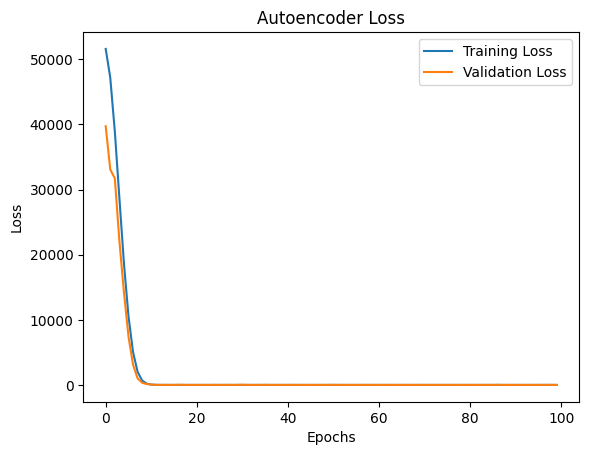

In [21]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


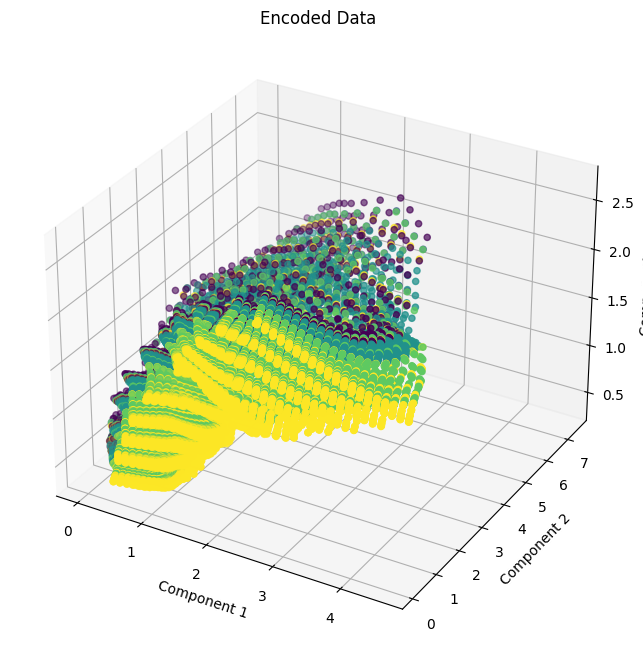

In [22]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(encoded_data_3[:, 0], encoded_data_3[:, 1], encoded_data_3[:, 2], c=y, cmap='viridis')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('Encoded Data')
plt.show()

* 4 features output

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout

# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the dimensions of the autoencoder
input_dim = X_train.shape[1]

encoding_dim = 4


# Define the autoencoder model
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(16, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(8, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)

decoder = Dense(8, activation='relu')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(16, activation='relu')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

import keras
opt = keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
autoencoder.compile(optimizer=opt, loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test))

# Get the encoded representation of the data
encoder_model_4 = Model(inputs=input_layer, outputs=encoder)
encoded_data_4 = encoder_model_4.predict(X)


Epoch 1/100
150/150 [==============================] - 2s 4ms/step - loss: 51582.0781 - val_loss: 47746.0234
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 47184.3125 - val_loss: 42333.2305
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 38943.5312 - val_loss: 34381.6250
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 28740.2871 - val_loss: 23483.2207
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: 18711.5000 - val_loss: 13986.0615
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 10543.1992 - val_loss: 7131.8262
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: 5031.1943 - val_loss: 2978.6282
Epoch 8/100
150/150 [==============================] - 0s 3ms/step - loss: 1999.7792 - val_loss: 923.8699
Epoch 9/100
150/150 [==============================] - 0s 3ms/step - loss: 662.8224 - val_loss: 300.4796
Epoch 10/100
150/150 [=======

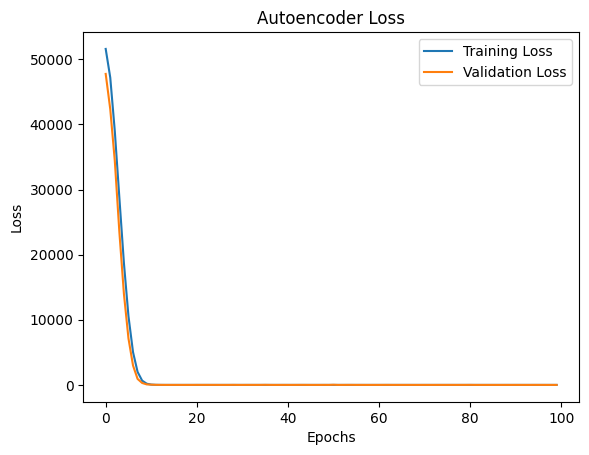

In [24]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


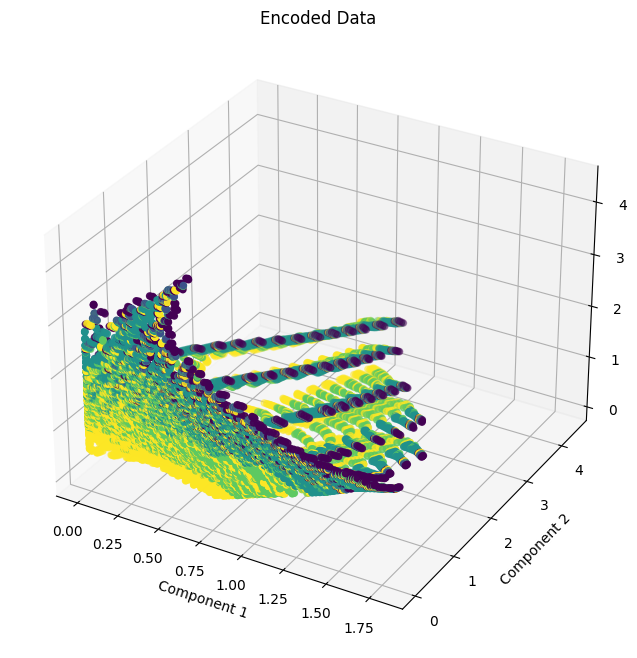

In [25]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(encoded_data_4[:, 0], encoded_data_4[:, 1], encoded_data_4[:, 2], c=y, cmap='viridis')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('Encoded Data')
plt.show()

# PCA

(27280, 3)


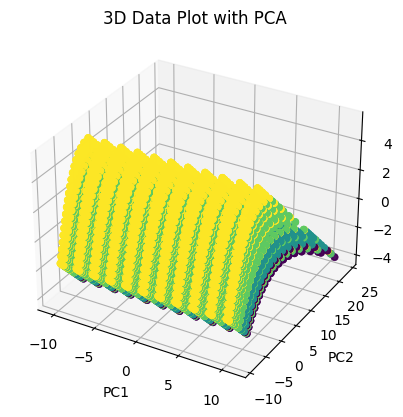

In [26]:
# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y)

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Data Plot with PCA')

# Show the plot
plt.show()


# LDA

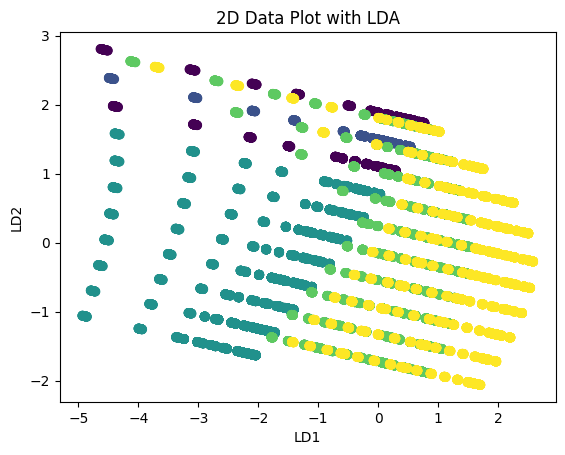

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=2) 
X_lda = lda.fit_transform(X, y)

# Create a 2D plot
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('2D Data Plot with LDA')
plt.show()


# Comparing all

In [28]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calculate silhouette score
silhouette = silhouette_score(X, y)
print("Silhouette Score of main data:", silhouette)

silhouette = silhouette_score(X_embed, y)
print("Silhouette Score of tsne output data:", silhouette)

silhouette = silhouette_score(encoded_data_3, y)
print("Silhouette Score of 3 features AE output data:", silhouette)

silhouette = silhouette_score(encoded_data_4, y)
print("Silhouette Score of 4 features AE output data:", silhouette)

silhouette = silhouette_score(X_pca, y)
print("Silhouette Score of pca output data:", silhouette)

silhouette = silhouette_score(X_lda, y)
print("Silhouette Score of lda output data:", silhouette)


print()
# Calculate Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(X, y)
print("Calinski-Harabasz Index of main data:", calinski_harabasz)

calinski_harabasz = calinski_harabasz_score(X_embed, y)
print("Calinski-Harabasz Index of tsne output data:", calinski_harabasz)

calinski_harabasz = calinski_harabasz_score(encoded_data_3, y)
print("Calinski-Harabasz Index of 3 features AE output data:", calinski_harabasz)

calinski_harabasz = calinski_harabasz_score(encoded_data_4, y)
print("Calinski-Harabasz Index of 4 features AE output data:", calinski_harabasz)

calinski_harabasz = calinski_harabasz_score(X_pca, y)
print("Calinski-Harabasz Index of pca output data:", calinski_harabasz)

calinski_harabasz = calinski_harabasz_score(X_lda, y)
print("Calinski-Harabasz Index of lda output data:", calinski_harabasz)

print()

# Calculate Davies-Bouldin index
davies_bouldin = davies_bouldin_score(X, y)
print("Davies-Bouldin Index of main data:", davies_bouldin)

davies_bouldin = davies_bouldin_score(X_embed, y)
print("Davies-Bouldin Index of tsne output data:", davies_bouldin)

davies_bouldin = davies_bouldin_score(encoded_data_3, y)
print("Davies-Bouldin Index of 3 features AE output data:", davies_bouldin)

davies_bouldin = davies_bouldin_score(encoded_data_4, y)
print("Davies-Bouldin Index of 4 features AE output data:", davies_bouldin)

davies_bouldin = davies_bouldin_score(X_pca, y)
print("Davies-Bouldin Index of pca output data:", davies_bouldin)

davies_bouldin = davies_bouldin_score(X_lda, y)
print("Davies-Bouldin Index of lda output data:", davies_bouldin)



Silhouette Score of main data: -0.025457842383237995
Silhouette Score of tsne output data: -0.044015173
Silhouette Score of 3 features AE output data: -0.026696546
Silhouette Score of 4 features AE output data: -0.017811231
Silhouette Score of pca output data: -0.025655223149941713
Silhouette Score of lda output data: 0.05253760398332844

Calinski-Harabasz Index of main data: 647.5649101758748
Calinski-Harabasz Index of tsne output data: 268.0483930135195
Calinski-Harabasz Index of 3 features AE output data: 675.0844408350973
Calinski-Harabasz Index of 4 features AE output data: 411.8250949577895
Calinski-Harabasz Index of pca output data: 657.9766426312244
Calinski-Harabasz Index of lda output data: 5271.187204452654

Davies-Bouldin Index of main data: 242.7819594743384
Davies-Bouldin Index of tsne output data: 254.8824327490932
Davies-Bouldin Index of 3 features AE output data: 177.54053137789325
Davies-Bouldin Index of 4 features AE output data: 293.8286470299288
Davies-Bouldin Inde